In [53]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

#Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

#WordCloud
from wordcloud import WordCloud, get_single_color_func
from os import path
from PIL import Image


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
import os

df_noPre = pd.read_csv('data.csv')
print(df_noPre.shape)
display(df_noPre)


(1539, 9)


,Unnamed: 0,title,rating,name,num_ratings,num_reviews,num_followers,synopsis,genre
0,0,Sapiens: A Brief History of Humankind,4.39,Yuval Noah Harari,"8,06,229","46,149",30.5k,"100,000 years ago, at least six human species ...",history
1,1,"Guns, Germs, and Steel: The Fates of Human Soc...",4.04,Jared Diamond,"3,67,056","12,879","6,538","""Diamond has written a book of remarkable scop...",history
2,2,A People's History of the United States,4.07,Howard Zinn,"2,24,620","6,509","2,354","In the book, Zinn presented a different side o...",history
3,3,"The Devil in the White City: Murder, Magic, an...",3.99,Erik Larson,"6,13,157","36,644",64.2k,Author Erik Larson imbues the incredible event...,history
4,4,The Diary of a Young Girl,4.18,Anne Frank,"33,13,033","35,591","4,621",Discovered in the attic in which she spent the...,history
...,...,...,...,...,...,...,...,...,...
1534,1534,Hounded,4.09,Kevin Hearne,"83,827","7,203","11,905","Atticus O’Sullivan, last of the Druids, lives ...",fantasy
1535,1535,Charlie and the Chocolate Factory,4.15,Roald Dahl,"7,75,001","14,252","22,897",Charlie Bucket's wonderful adventure begins wh...,fantasy
1536,1536,Red Rising,4.25,Pierce Brown,"3,10,138","30,388","30,510","""I live for the dream that my children will be...",fantasy
1537,1537,Frostbite,4.26,Richelle Mead,"3,37,538","12,435","66,448","Rose loves Dimitri, Dimitri might love Tasha, ...",fantasy


In [55]:
##Baseret på: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

df_noPre['synopsis_tok']=[nltk.word_tokenize(i) for i in df_noPre['synopsis']] 
model = Word2Vec(df_noPre['synopsis_tok'],min_count=1) 
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [56]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_noPre["synopsis"],
                                                  df_noPre["genre"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [57]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))

                 precision    recall  f1-score   support

        fantasy       0.81      0.89      0.85        73
        history       0.75      0.62      0.68        24
         horror       0.75      0.11      0.19        27
     psychology       0.94      0.76      0.84        21
        romance       0.60      0.32      0.41        19
        science       0.90      0.82      0.86        11
science_fiction       1.00      0.17      0.29         6
         sports       0.86      0.50      0.63        12
       thriller       0.65      0.98      0.78        95
         travel       0.93      0.70      0.80        20

       accuracy                           0.74       308
      macro avg       0.82      0.59      0.63       308
   weighted avg       0.76      0.74      0.71       308



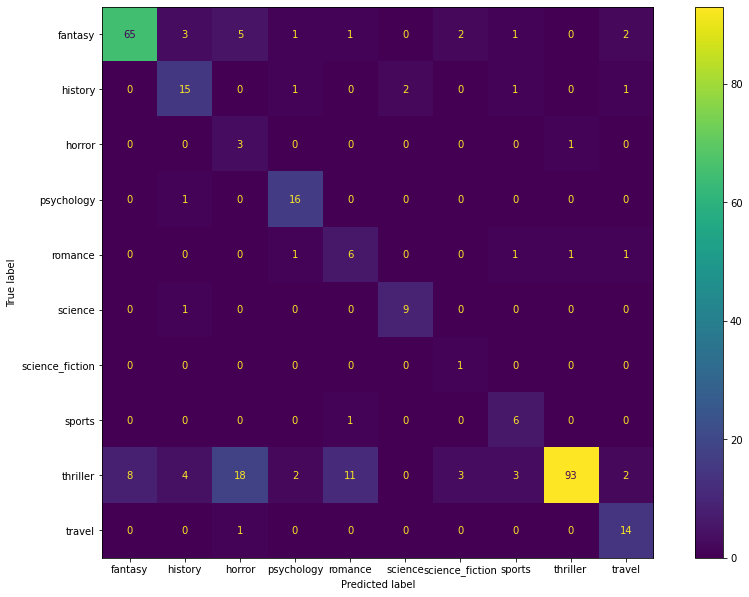

In [58]:
ConfusionMatrixDisplay.from_predictions(y_predict,y_val)  
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=(0,0,2.1,2.1));
plt.savefig('ConfusionMatrixNocleansing.pdf',bbox_inches='tight')
plt.show()

# Wordclouds before cleansing

In [61]:
his = df_noPre.loc[df_noPre['genre']== 'history']
fan = df_noPre.loc[df_noPre['genre']=='fantasy']
thr = df_noPre.loc[df_noPre['genre']=='thriller']
hor = df_noPre.loc[df_noPre['genre']=='horror']
sci = df_noPre.loc[df_noPre['genre']=='science']
rom = df_noPre.loc[df_noPre['genre']=='romance']
sciFi = df_noPre.loc[df_noPre['genre']=='science_fiction']
spor = df_noPre.loc[df_noPre['genre']=='sports']
tra = df_noPre.loc[df_noPre['genre']=='travel']
psy = df_noPre.loc[df_noPre['genre']=='psychology']

# History

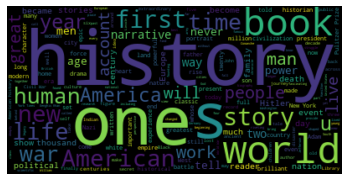

In [62]:
text = ' '.join(genre for genre in his.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('historyNC.pdf',bbox_inches='tight')
plt.show()

# Fantasy

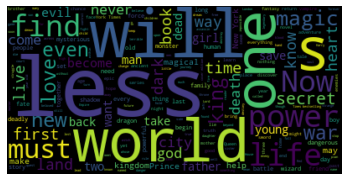

In [63]:
text = ' '.join(genre for genre in fan.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('FantasyNC.pdf',bbox_inches='tight')
plt.show()

# Thriller

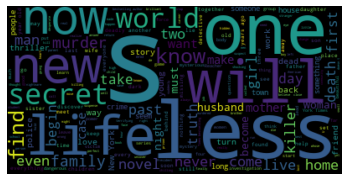

In [64]:
text = ' '.join(genre for genre in thr.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('ThrillerNC.pdf',bbox_inches='tight')
plt.show()

# Horror

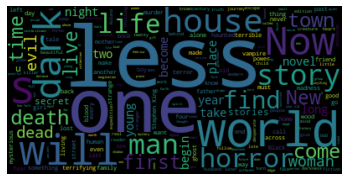

In [65]:
text = ' '.join(genre for genre in hor.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('horrorNC.pdf',bbox_inches='tight')
plt.show()

# Science

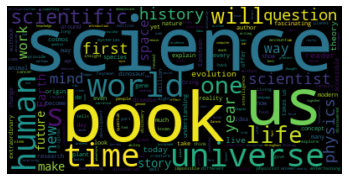

In [66]:
text = ' '.join(genre for genre in sci.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('ScienceNC.pdf',bbox_inches='tight')
plt.show()

# Science Fiction

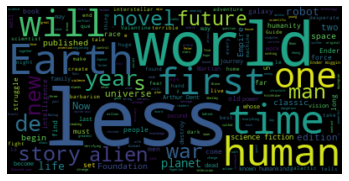

In [67]:
text = ' '.join(genre for genre in sciFi.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('Science_fictionNC.pdf',bbox_inches='tight')
plt.show()

# Travel

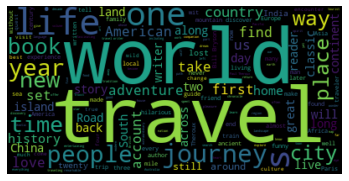

In [68]:
text = ' '.join(genre for genre in tra.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('TravelNC.pdf',bbox_inches='tight')
plt.show()

# Romance

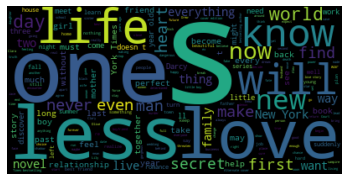

In [69]:
text = ' '.join(genre for genre in rom.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('RomanceNC.pdf',bbox_inches='tight')
plt.show()

# Psychology

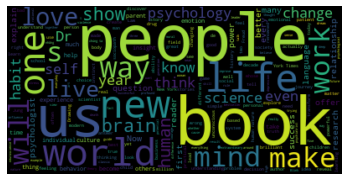

In [70]:
text = ' '.join(genre for genre in psy.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('PsychologyNC.pdf',bbox_inches='tight')
plt.show()

# Sports

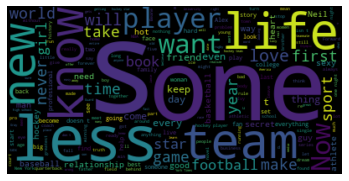

In [71]:
text = ' '.join(genre for genre in spor.synopsis)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('SportsNC.pdf',bbox_inches='tight')
plt.show()